In [19]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from keras import layers, models, regularizers   # Import models here
from keras.callbacks import EarlyStopping

In [20]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1


In [21]:
background = np.load('Datasets/background.npz')['data']
bbh = np.load('Datasets/bbh_for_challenge.npy')
sglf = np.load('Datasets/sglf_for_challenge.npy')


In [22]:
background.shape, bbh.shape, sglf.shape

((100000, 2, 200), (100000, 2, 200), (100000, 2, 200))

In [23]:
bbh

array([[[ 1.03012301e+00,  6.66234931e-01,  2.75682791e-01, ...,
         -2.60990943e-01, -5.84393959e-01, -7.46497385e-01],
        [-6.27454114e-02, -1.84487786e-01,  3.88559400e-01, ...,
         -3.36276782e-01,  1.01263768e+00,  3.80964610e-01]],

       [[ 1.74979840e-01,  7.48266345e-01,  7.24211640e-01, ...,
         -4.63622030e-01,  1.05639532e-01, -5.14535730e-01],
        [-1.95504422e-01, -2.33750909e-01, -2.80466593e-01, ...,
          4.68445328e-01,  5.14595869e-01,  1.75297586e-01]],

       [[-4.33038517e-01, -6.44210364e-02, -5.06945784e-02, ...,
         -1.23892618e+00, -5.15168298e-01, -1.40534826e-01],
        [ 5.88572449e-01,  4.23104898e-01, -8.21322389e-04, ...,
          5.09951853e-01,  3.73084958e-01,  8.12072346e-01]],

       ...,

       [[ 1.23303802e+00, -2.59893629e-02,  2.84386656e-01, ...,
          2.83659281e-01,  5.65552664e-01, -3.75204062e-01],
        [-3.55021412e-01, -8.93913081e-01, -7.67647471e-01, ...,
         -1.59143451e-01, -6.23624

In [24]:
def normalize(data):
    stds = np.std(data, axis=-1, keepdims=True)
    return data / stds

background = normalize(background)
bbh = normalize(bbh)
sglf = normalize(sglf)

# Reshape for input (N, 200, 2)
background = np.swapaxes(background, 1, 2)
bbh = np.swapaxes(bbh, 1, 2)
sglf = np.swapaxes(sglf, 1, 2)

# Train-test split
x_train, x_test = train_test_split(background, test_size=0.2, random_state=42)
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (80000, 200, 2), x_test shape: (20000, 200, 2)


In [25]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
bbh = torch.tensor(bbh, dtype=torch.float32)
sglf = torch.tensor(sglf, dtype=torch.float32)

train_loader = data.DataLoader(x_train, batch_size=32, shuffle=True)
test_loader = data.DataLoader(x_test, batch_size=32)

In [26]:
x_train

tensor([[[ 1.0816e-01, -1.9766e-01],
         [ 1.4978e+00,  5.5721e-01],
         [ 3.6435e-02,  1.6261e-01],
         ...,
         [-1.4395e+00,  6.0632e-01],
         [ 2.3400e-01, -8.9648e-01],
         [ 7.6040e-01,  3.5828e-01]],

        [[ 3.1589e-01, -7.9441e-03],
         [-1.4725e+00, -8.4088e-01],
         [ 1.2018e+00,  6.4890e-01],
         ...,
         [-6.1532e-02,  6.8431e-01],
         [-1.6482e+00,  1.2364e+00],
         [-1.0989e-01,  1.7851e-01]],

        [[-1.1002e+00, -1.4601e+00],
         [-2.9973e+00, -8.9437e-01],
         [-1.7873e+00,  5.9734e-01],
         ...,
         [-3.9129e-01,  1.4526e+00],
         [-1.6654e-03,  1.6046e+00],
         [-6.3719e-01,  2.3701e-03]],

        ...,

        [[ 7.2332e-01,  5.0923e-01],
         [ 8.7910e-01, -2.8438e-01],
         [-1.3622e+00, -2.2517e-01],
         ...,
         [ 6.5532e-01, -1.9410e-05],
         [ 5.0692e-01, -8.8732e-01],
         [ 6.0942e-01, -4.4532e-01]],

        [[-1.2930e+00,  1.8066e-01

# One class SVM

## Introduction

One class SVM is a novelty detection method for datasets that are clean and not polluted by anomalies. 
> Different from traditional outlier detection, which is use to find anomaly datapoints in existing data, novelty detection determines whether a new datapoint belongs to our current distribution. It is a semi-supervised anomaly detection method. 

Usual SVMs separate data into several different classes. In the case of one class SVM, we simply determine a boundary based on the available data, and anything outside of this boundary is considered anomaly. 

Important Hyperparameters in One-class SVM: 
- nu: proportion of outliers allowed. Default 0.5. 
- kernel: determines the type of decision boundary the SVM uses. Common choices include ‘linear,’ ‘rbf’ (Gaussian radial basis function), ‘poly’ (polynomial), and ‘sigmoid.’ The ‘rbf’ kernel is often used as it can effectively capture complex non-linear relationships.
    - kernel parameters (degree, coef0): for polynomial and sigmoid kernels. 
- gamma: determines how much influence a single training example has. Parameter for non-linear hyperplanes. The larger this value, the closer must be for other examples to be affected. 
- tol: stopping criterion. 




### Using One class SVM: Preprocessing data

SVM models take in 1D data, thus we need to preprocess the data given (dimensions (N, 200, 2)). We will try two methods: 
1. Flattening data: Straight up exploding the array into (N,400). 
    - Potential problem with flattening: this method disregards the temporal and spatial relationships between the data taken by the two different LIGO stations. The structural relationships between the two streams are lost. 
2. Feature engineering: compute a joint feature that captures the correlations between the two streams. We will try cross correlation and coherence. 


**1. Flattening data**

In [27]:
x_train_np = x_train.numpy()
N = x_train_np.shape[0]
flattened_data = x_train_np.reshape(N, -1)  # Shape: (N, 400)
flattened_data

array([[ 1.08158424e-01, -1.97661668e-01,  1.49781060e+00, ...,
        -8.96481872e-01,  7.60398507e-01,  3.58279347e-01],
       [ 3.15889657e-01, -7.94408470e-03, -1.47252595e+00, ...,
         1.23643363e+00, -1.09888531e-01,  1.78508669e-01],
       [-1.10016930e+00, -1.46005297e+00, -2.99730825e+00, ...,
         1.60455453e+00, -6.37189925e-01,  2.37005739e-03],
       ...,
       [ 7.23320186e-01,  5.09228587e-01,  8.79097760e-01, ...,
        -8.87319803e-01,  6.09418690e-01, -4.45315599e-01],
       [-1.29296434e+00,  1.80661395e-01, -7.24424541e-01, ...,
         9.69739079e-01, -8.30165505e-01, -3.98187637e-01],
       [-1.56296372e+00, -1.78068304e+00, -1.39100969e+00, ...,
         9.26624954e-01, -9.19920206e-01,  5.89446366e-01]], dtype=float32)

Scrapped ^

# Isolation Forest

In [28]:
# Step 1: Convert to numpy and flatten
x_train_np = x_train.numpy()  # Convert to NumPy array
N = x_train_np.shape[0]
x_train_flattened = x_train_np.reshape(N, -1)  # Shape: (N, 400)

# Step 3: Train Isolation Forest
clf = IsolationForest(n_estimators=100, contamination=0.5, random_state=42)
clf.fit(x_train_flattened)

x_test_np = x_test.numpy()
x_test_flattened = x_test_np.reshape(x_test.shape[0], -1)

# Predict
predictions = clf.predict(x_test_flattened)
print("Predictions:", predictions)  # 1 for inliers, -1 for outliers


Predictions: [-1 -1 -1 ... -1  1  1]


In [29]:
true_labels_test = np.ones(x_test_flattened.shape[0])
accuracy = accuracy_score(predictions, true_labels_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 50.02%


In [30]:
bbh_flattened = bbh.numpy().reshape(bbh.shape[0], -1)
bbh_predictions = clf.predict(bbh_flattened)
print("Predictions:", bbh_predictions) 

true_labels_bbh = -1 * np.ones(len(bbh_predictions))
accuracy_bbh = (bbh_predictions == true_labels_bbh).mean()
print(f"Accuracy on anomaly dataset: {accuracy_bbh * 100:.2f}%")

Predictions: [ 1 -1 -1 ... -1 -1 -1]
Accuracy on anomaly dataset: 51.57%


## Try a different way of splitting the data

In [31]:
# Extract Hanford and Livingston data
hanford_data = x_train[:, :, 0]  # Shape: (N, 200)
livingston_data = x_train[:, :, 1]  # Shape: (N, 200)

# Now you have two separate lists (for each stream)


In [32]:
# Combine both streams for each segment (still keeping the two streams intact)
x_train_combined = np.concatenate([hanford_data, livingston_data], axis=1)  # Shape: (N, 400)

# Train Isolation Forest
clf = IsolationForest(n_estimators=300, contamination=0.01, random_state=42)
clf.fit(x_train_combined)

# For prediction
x_test_combined = np.concatenate([x_test[:, :, 0], x_test[:, :, 1]], axis=1)  # Shape: (N, 400)
predictions = clf.predict(x_test_combined)


In [33]:
true_labels_test = np.ones(x_test_combined.shape[0])  # All normal data should be inliers (label = 1)
accuracy_test = accuracy_score(predictions, true_labels_test)
print(f"Accuracy on normal data: {accuracy_test * 100:.2f}%")

Accuracy on normal data: 98.89%


In [34]:
# Prepare anomaly data (Hanford and Livingston combined)
hanford_bbh = bbh[:, :, 0]  # Shape: (N, 200)
livingston_bbh = bbh[:, :, 1]  # Shape: (N, 200)

# Combine both streams for each segment (Shape: (N, 400))
bbh_combined = np.concatenate([hanford_bbh, livingston_bbh], axis=1)

# Predict on anomaly data (bbh)
bbh_predictions = clf.predict(bbh_combined)
true_labels_bbh = -1 * np.ones(len(bbh_predictions))  # All anomalies should be outliers (label = -1)
accuracy_bbh = (bbh_predictions == true_labels_bbh).mean()
print(f"Accuracy on anomaly dataset: {accuracy_bbh * 100:.2f}%")


KeyboardInterrupt: 

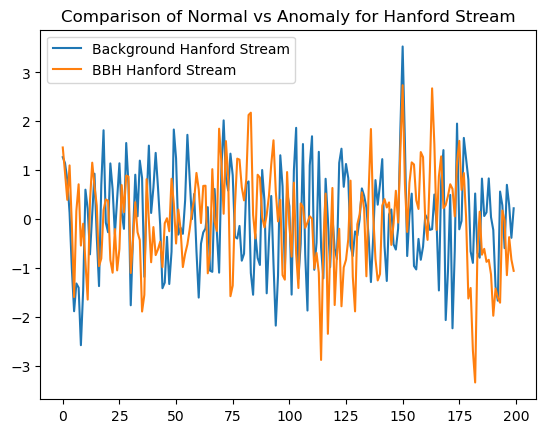

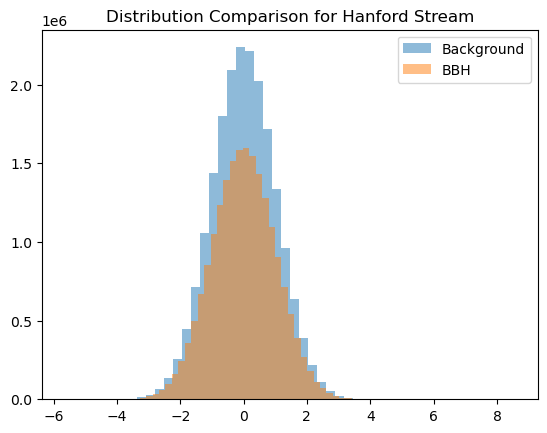

In [43]:
import matplotlib.pyplot as plt

# Plot time series of a random segment
plt.plot(background[0, :, 0], label='Background Hanford Stream')
plt.plot(bbh[0, :, 0], label='BBH Hanford Stream')
plt.legend()
plt.title('Comparison of Normal vs Anomaly for Hanford Stream')
plt.show()

# Plot distributions (for example, for the first feature)
plt.hist(background[:, :, 0].flatten(), bins=50, alpha=0.5, label='Background')
plt.hist(bbh[:, :, 0].flatten(), bins=50, alpha=0.5, label='BBH')
plt.legend()
plt.title('Distribution Comparison for Hanford Stream')
plt.show()


In [ ]:
# Compute mean and std for each feature across all segments
background_mean = np.mean(background, axis=(0, 1))  # Mean across N segments
bbh_mean = np.mean(bbh.numpy(), axis=(0, 1))

background_std = np.std(background, axis=(0, 1))
bbh_std = np.std(bbh.numpy(), axis=(0, 1))

print(f"Background Mean: {background_mean}")
print(f"BBH Mean: {bbh_mean}")
print(f"Background Std: {background_std}")
print(f"BBH Std: {bbh_std}")


Background Mean: [-3.78367051e-06  8.95767795e-05]
BBH Mean: [-1.7346883e-05 -1.1343344e-04]
Background Std: [1.00025176 1.00022379]
BBH Std: [1.0005262 1.0007108]


# CNN 

In [ ]:
from tensorflow.keras import layers, models, regularizers

input_shape = (200, 2)

model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape, 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    # Change the output layer to softmax for multi-class classification
    layers.Dense(3, activation='softmax')  # 3 classes: background, BBH, SGJF
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/Users/rebeccachen/miniforge3/envs/dsc80/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 198, 16)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 99, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 97, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 46, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       188,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,819 (768.82 KB)

 Trainable params: 196,819 (768.82 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Transpose the datasets to match the required shape (N, 200, 2)
background = background.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
bbh = bbh.transpose(0, 2, 1)                # Shape: (100000, 200, 2)
sglf = sglf.transpose(0, 2, 1)              # Shape: (100000, 200, 2)

# Combine datasets
X = np.concatenate([background, bbh, sglf], axis=0)  # Shape: (300000, 200, 2)

# Create labels: 0 for background, 1 for BBH, 2 for SGJF
y = np.concatenate([
    np.zeros(background.shape[0], dtype=int),  # Shape: (100000,)
    np.ones(bbh.shape[0], dtype=int),          # Shape: (100000,)
    np.full(sglf.shape[0], 2, dtype=int)       # Shape: (100000,)
])

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [40]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training (90%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=20, 
    batch_size=64
)

Epoch 1/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8781 - loss: 0.7058 - val_accuracy: 0.9540 - val_loss: 0.2889
Epoch 2/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9434 - loss: 0.3080 - val_accuracy: 0.9659 - val_loss: 0.2422
Epoch 3/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9549 - loss: 0.2637 - val_accuracy: 0.9747 - val_loss: 0.2040
Epoch 4/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9605 - loss: 0.2369 - val_accuracy: 0.9650 - val_loss: 0.2244
Epoch 5/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9631 - loss: 0.2272 - val_accuracy: 0.9742 - val_loss: 0.1898
Epoch 6/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9649 - loss: 0.2168 - val_accuracy: 0.9790 - val_loss: 0.1745
Epoch 7/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9646 - loss: 0.2094 - val_accuracy: 0.9793 - val_loss: 0.1712
Epoch 8/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9659 - loss: 0

In [41]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9756 - loss: 0.1612
Test Loss: 0.16172869503498077, Test Accuracy: 0.9754833579063416


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


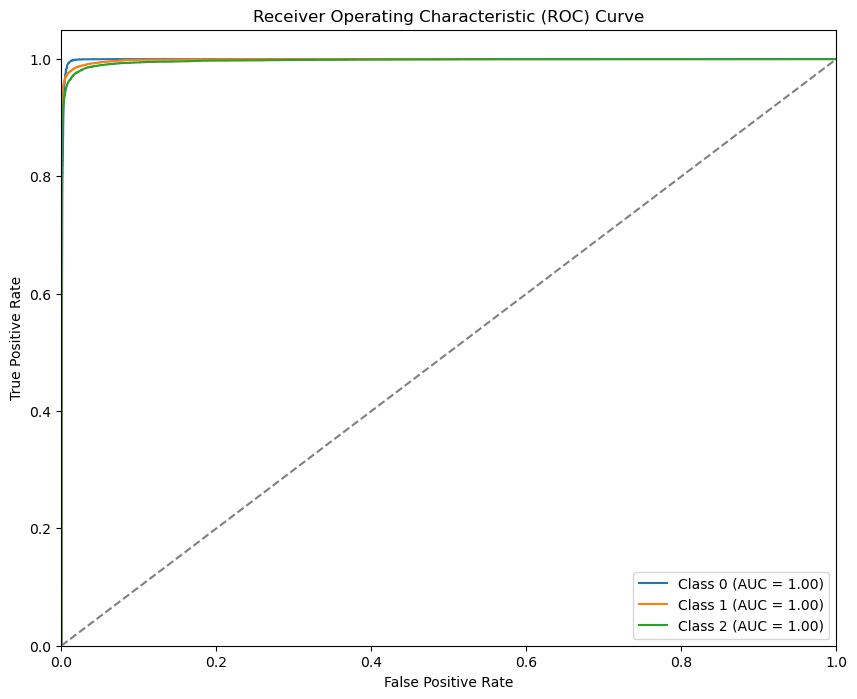

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Make predictions on the test set (output is probabilities for each class)
y_pred = model.predict(X_test)

# Binarize the labels for multi-class classification (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 0, 1, 2 are your classes

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # 3 classes: background, BBH, SGJF
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (no discrimination)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Labeling the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()
